## Machine Learning

In [ ]:
# pip install scikit-surprise
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

import gc

In [ ]:
df1 = pd.read_parquet(('data/merge.parquet'))
df_title = pd.read_csv('data/df_title.csv')

In [ ]:
reader = Reader()
N_filas = 100000 # Limitamos el dataset a N_filas
data = Dataset.load_from_df(df1[['userId', 'movieId', 'score']][:N_filas], reader)

In [ ]:
# Separamos nuestros datos, modelo SVD, 
trainset, testset = train_test_split(data, test_size=.25)
model = SVD()
model.fit(trainset)
predictions = model.test(testset)

In [ ]:
# df_title = pd.read_csv('data/df_title.csv')
# df_title = df_title[['movieId','title']]
# df_title

In [ ]:
# Tomaremos un usuario para hacerle una recomendación
usuario = 124380
rating = 4.5   # Tomamos películas a las que haya calificado con 4 o 5 estrellas
df_user = df1[(df1['userId'] == usuario) & (df1['score'] >= rating)] # Filtra por usuario y score > rating
df_user = df_user.reset_index(drop=True) # Resetea el index
# df_user = df_user.drop('Unnamed: 0', axis=1)
df_user

In [ ]:
df_title.iloc[:4499].copy()

In [ ]:
recomendaciones_usuario = df_title.iloc[:4499].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

In [ ]:
# Debemos extraer las películas que ya ha visto
usuario_vistas = df1[df1['userId'] == usuario] # Filtro por peliculas que el usuario califico
print(usuario_vistas.shape)
# usuario_vistas = usuario_vistas.drop('Unnamed: 0', axis=1)
usuario_vistas['movieId'].values

In [ ]:
recomendaciones_usuario.drop(usuario_vistas.movieId, inplace = True,  errors='ignore')
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario

In [ ]:
# Recomendamos
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['movieId'].apply(lambda x: model.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

In [19]:
# Evaluamos
accuracy.rmse(predictions)

RMSE: 1.0028


1.0028143582116535

## Optimizacion de hiperparametros

In [17]:
# Optimizacion de hiperparametros
# Realiza una validación cruzada con diferentes valores de un hiperparámetro (número de factores latentes) en un modelo SVD. 
# El objetivo es encontrar el valor de este hiperparámetro que da lugar al menor valor medio de RMSE para un conjunto de datos dado.
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9914  0.9832  0.9845  0.9864  0.0036  
Fit time          1.34    0.75    0.63    0.91    0.31    
Test time         0.46    0.48    0.35    0.43    0.06    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9882  0.9853  0.9836  0.9857  0.0019  
Fit time          0.65    0.89    0.93    0.82    0.12    
Test time         0.41    0.70    0.41    0.50    0.14    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9880  0.9928  0.9778  0.9862  0.0063  
Fit time          0.72    0.67    0.69    0.69    0.02    
Test time         0.44    0.49    0.33    0.42    0.07    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9845  0.9

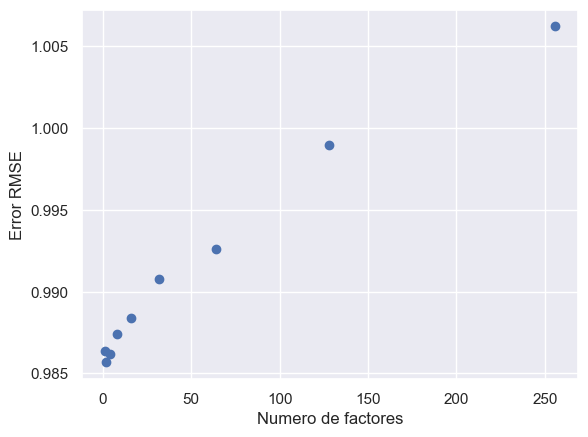

In [18]:
# Ploteamos desempeño según cantidad de factores de SVD

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [ ]:
# Este codigo tiene un tiempo de ejecucion extenso.
# Este código utiliza la función GridSearchCV de la biblioteca surprise para realizar la sintonización de hiperparámetros del modelo SVD.
# param_grid contiene valores para hiperparámetros como el número de factores latentes, número de épocas, tasa de aprendizaje y regularización.
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
# GridSearchCV realiza una búsqueda en cuadrícula sobre todas las posibles combinaciones de hiperparámetros y 
# evalúa el rendimiento del modelo utilizando validación cruzada. 
# En este caso, la métrica de evaluación utilizada es el RMSE, y el parámetro cv especifica el número de pliegues de validación cruzada.
# Al establecer n_jobs en -1, utiliza todos los núcleos de CPU disponibles para acelerar el proceso de optimización de hiperparámetros.
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [ ]:
# Observamos performance del mejor modelo

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

## Incorporacion de nuevos datos

In [ ]:
# Incorporacion de nuevos datos
def load_data(name):
    df = pd.read_csv(name, header = None, names = ['userId','score'], usecols = [0,1])
    
    # En ciertos casos, forzar un tipo de dato hace que se ahorre mucho lugar en memoria.
    df['score'] = df['score']#.astype(float) 
    return df


# df2 = load_data() Aqui se cargan los datos nuevos
# print(df2.shape)

In [ ]:
movies_ids_df2 = df2.userId[df2.score.isna()].values
print(movies_ids_df2)
print(len(movies_ids_df2))

movies_ids_df2 = np.arange(4500,len(movies_ids_df2) + 4500)
print(movies_ids_df2)

In [ ]:
df2_nan = pd.DataFrame(pd.isnull(df2.score))
df2_nan = df2_nan[df2_nan['score'] == True]
idx_movies_ids = df2_nan.index.values
print(idx_movies_ids)

In [ ]:
# Agregamos el índice de la última instancia del DataFrame
idx_movies_ids = np.append(idx_movies_ids,df2.shape[0])

In [ ]:
cantidad_criticas = np.diff(idx_movies_ids)
cantidad_criticas

In [ ]:
columna_movie_id = np.array([])
for i in range(cantidad_criticas.size):
    aux = np.full(cantidad_criticas[i], movies_ids_df2[i])
    columna_movie_id = np.concatenate((columna_movie_id, aux))

In [ ]:
df2['movieId'] = columna_movie_id
del columna_movie_id

df2.dropna(inplace = True)
df2['userId'] = df2['userId'].astype(int)
df2['movieId'] = df2['movieId'].astype(np.int16)
df2['score'] = df2['score'].astype(np.int8)

gc.collect()

In [ ]:
### 5.
df = df1.copy()
del df1
df = df.append(df2)
print(df.shape)

In [ ]:
# Corroboramos que estén todas las películas

peliculas_presentes = df.movie_id.unique()
peliculas_presentes

In [ ]:
print((peliculas_presentes - np.arange(1,9210 + 1)).sum())

In [ ]:
# Y asi sucesivamente
switch = False
if switch:
    df.to_parquet('data/ML.parquet', index= False)